# Classification Part 1

Initially we tried analytically explore features for the classifier in the 'features_explored' notebooks. But soon enough we realised that doing this was a time consuning process. So we went through the questionaire and chose questions, that we deemed, could be related to political leaning. Such as achieved education level, monthly income, employement, amongst few. In the notebook bellow we use these features and see how well intuitively (manually) chosen features perform in the classification of political leaning.

## I) Import the neccessary libraries and the dataframe

In [8]:
# Import libaries used in the notebook.
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', 'raise')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import seaborn as sns

# Suppress warning about mixed data types in columns (change this later?)
import warnings
warnings.filterwarnings('ignore')

# Import Some of the useful defined functions
import useful_fun as uf
# object with different useful regions defined
regions = uf.Regions()

In [9]:
# Extract the the zipped csv data if it already hasn't been extracted 
import os.path
import zipfile

if not os.path.isfile('./data/LiTS_III_2016.csv'):
    with zipfile.ZipFile("./data/LiTS_III_2016.zip","r") as zip_ref:
        zip_ref.extractall("./data/")
else:
    print('File already present')

File already present


In [10]:
# Reading the dataframe
lits_2016_full = pd.read_csv('./data/LiTS_III_2016.csv') # data in the repo folder linux
# lits_2016 = pd.read_csv('LiTS III.csv')

## II) Select the manually chosen features from the dataset. Adjust and prepare it for use in classification.

### The following are the question columns we chose based on the contents of the questions, to make k-NN classifier for determening political inclination.

In [11]:
# Select only the columns we're interested in (can increase this as we go along)
good_cols = [
'country',#     'Country',                         # Categorical
'gender_pr',#   'Gender',                          # Categorical
'q204',#        'Internet Acess',                  # Categorical
'age_pr',#      'Age',                             # Numerical
'q223',#        'Monthly Income',                  # Numerical
'q109_1',#      'Education Level',                 # Numerical
'q203',#        'Books Growing Up',                # Numerical
'q403',#        'Trust in People',                 # Numerical
'q428',#        'Risktaking',                      # Numerical
'q901',#        'State of Health',                 # Numerical
'q904a',#       'News:Newspaper',                  # Numerical
'q904b',#       'News:Radio or Tv',                # Numerical
'q904c',#       'News:Printed Magazine',           # Numerical
'q904d',#       'News:In Depth TV / Radio',        # Numerical
'q904e',#       'News:Internet Email',             # Numerical
'q904f',#       'News:Family Friends',             # Numerical
'q904g',#       'News:Social Media',               # Numerical
'q905',#        'TV Time Yesterday',               # Numerical
'q412',#        'Political System',                # Categorical
'q411',#        'Economy Type',                    # Categorical
# added from regression analysis
'q401e',      # 'Life Satisfaction',               # Numerical
'q401c',      # 'Parents',                         # Numerical
'q421',       # 'Inequality',                      # Numerical
'q424',       # 'Socialising',                     # Numerical
'PRq502',     # 'Employment',                      # Categorical
'PRq315',     # 'Wealth Level',                    # Numerical
'PRq316',     # 'Past Wealth Level',               # Numerical
'PRq317',     # 'Predicted Wealth Level',          # Numerical
'q901',       # 'Health',                          # Numerical
]
lits_2016_selected = lits_2016_full[good_cols]

# Give the columns new names
good_names = [
'Country',
'Gender',
'Internet Acess',
'Age',
'Monthly Income',
'Education Level',
'Books Growing Up',
'Trust in People',
'Risktaking',
'State of Health',
'News:Newspaper',
'News:Radio or Tv',
'News:Printed Magazine',
'News:In Depth TV / Radio',
'News:Internet Email',
'News:Family Friends',
'News:Social Media',
'TV Time Yesterday',
'Political System',
'Economy Type',
# added from regression analysis
'Life Satisfaction',
'Parents',
'Inequality',
'Socialising',
'Employment',
'Wealth Level',
'Past Wealth Level',
'Predicted Wealth Level',
'Health',
]
lits_2016_selected.columns = good_names


# Drop values nan values we cannot use
lits_2016_selected = lits_2016_selected.dropna()

# # Also set all the datatypes as int. (Makes operations with the dataframe more efficient)
lits_2016_selected.iloc[:,1:] = lits_2016_selected.iloc[:,1:].astype(int)
lits_2016_selected.head()

,Country,Gender,Internet Acess,Age,Monthly Income,Education Level,Books Growing Up,Trust in People,Risktaking,State of Health,...,Economy Type,Life Satisfaction,Parents,Inequality,Socialising,Employment,Wealth Level,Past Wealth Level,Predicted Wealth Level,Health
1,Albania,1,2,58,50000,2,1,1,3,3,...,1,2,2,2,3,1,5,6,6,3
2,Albania,1,3,40,-99,7,1,1,2,3,...,2,2,2,2,3,1,5,6,7,3
3,Albania,1,2,58,30000,2,1,1,2,3,...,2,2,2,2,2,1,5,5,6,3
6,Albania,1,3,48,80000,7,2,1,3,2,...,2,4,4,2,3,1,5,6,7,2
8,Albania,2,4,52,30000,2,1,1,2,3,...,1,2,2,2,5,2,6,6,6,3


In [26]:
# Check that the values were replaced
def column_values(df):
    for col in df.columns:
        # unique = np.unique(lits_2016_selected[col])
        unique = df[col].unique()
        # for i in 
        if len(unique) < 14:
            print('{}\n {}, Members: ({})'.format(col,len(unique),unique))
        else:
            print('{}\n {}, Members: (mora than 10)'.format(col,len(unique)))

column_values(lits_2016_selected)

Country
 33, Members: (mora than 10)
Gender
 2, Members: (['men' 'women'])
Internet Acess
 4, Members: ([2 3 4 1])
Age
 78, Members: (mora than 10)
Monthly Income
 1335, Members: (mora than 10)
Education Level
 8, Members: ([2 7 4 3 6 8 5 1])
Books Growing Up
 7, Members: ([  1   2   4   3   5 -97 -98])
Trust in People
 6, Members: ([  1   2   4   3   5 -91])
Risktaking
 11, Members: ([  3   2   4   6   1   9   7   8   5  10 -97])
State of Health
 6, Members: ([  3   2   1   4 -97   5])
News:Newspaper
 7, Members: ([6 7 2 1 5 4 3])
News:Radio or Tv
 7, Members: ([6 7 2 5 1 3 4])
News:Printed Magazine
 7, Members: ([6 7 2 1 3 4 5])
News:In Depth TV / Radio
 7, Members: ([6 7 2 1 5 4 3])
News:Internet Email
 7, Members: ([6 1 7 5 3 4 2])
News:Family Friends
 7, Members: ([6 2 7 5 1 3 4])
News:Social Media
 7, Members: ([6 2 1 7 5 3 4])
TV Time Yesterday
 25, Members: (mora than 10)
Political System
 4, Members: (['democratic' 'authoritarian' 'indifferent' 'dont know'])
Economy Type
 4, M

In [27]:
# Set different catergorical classes to strings to make it clearer
replace = {'Political System':{
 1: 'democratic',
 2: 'authoritarian',
 3: 'indifferent',
 -97 : 'dont know'},
 'Economy Type':{
 1: 'capitalist',
 2: 'social',
 3: 'indifferent',
 -97 : 'dont know'},
 'Gender':{
 1: 'men',
 2: 'women'}
 }
lits_2016_selected = lits_2016_selected.replace(replace);

# Check if they were replaced correctly 
column_values(lits_2016_selected)

Country
 33, Members: (mora than 10)
Gender
 2, Members: (['men' 'women'])
Internet Acess
 4, Members: ([2 3 4 1])
Age
 78, Members: (mora than 10)
Monthly Income
 1335, Members: (mora than 10)
Education Level
 8, Members: ([2 7 4 3 6 8 5 1])
Books Growing Up
 7, Members: ([  1   2   4   3   5 -97 -98])
Trust in People
 6, Members: ([  1   2   4   3   5 -91])
Risktaking
 11, Members: ([  3   2   4   6   1   9   7   8   5  10 -97])
State of Health
 6, Members: ([  3   2   1   4 -97   5])
News:Newspaper
 7, Members: ([6 7 2 1 5 4 3])
News:Radio or Tv
 7, Members: ([6 7 2 5 1 3 4])
News:Printed Magazine
 7, Members: ([6 7 2 1 3 4 5])
News:In Depth TV / Radio
 7, Members: ([6 7 2 1 5 4 3])
News:Internet Email
 7, Members: ([6 1 7 5 3 4 2])
News:Family Friends
 7, Members: ([6 2 7 5 1 3 4])
News:Social Media
 7, Members: ([6 2 1 7 5 3 4])
TV Time Yesterday
 25, Members: (mora than 10)
Political System
 4, Members: (['democratic' 'authoritarian' 'indifferent' 'dont know'])
Economy Type
 4, M

### Most of the features we selected manually are rather numerical in nature, but sometimes have an option to be answered categorically. We chose to drop those parts of the numerical questions

Remove the following:  
* -91 - difficult to say
* -99 - refusal
* -97 - don't know
* -98 - not applicable

In [29]:
exclusion_criteria = [np.nan, -97, -99, -98, -91]
meassure = lits_2016_selected.columns
lits_2016_selected_clean = uf.exclude_values(lits_2016_selected,meassure,exclusion_criteria)

# Check if excluded values were removed
column_values(lits_2016_selected_clean)

Country
 33, Members: (mora than 10)
Gender
 2, Members: (['men' 'women'])
Internet Acess
 4, Members: ([2 3 4 1])
Age
 78, Members: (mora than 10)
Monthly Income
 1160, Members: (mora than 10)
Education Level
 8, Members: ([2 7 3 4 6 8 5 1])
Books Growing Up
 5, Members: ([1 2 4 3 5])
Trust in People
 5, Members: ([1 2 4 3 5])
Risktaking
 10, Members: ([ 3  2  4  6  1  9  7  8  5 10])
State of Health
 5, Members: ([3 2 1 4 5])
News:Newspaper
 7, Members: ([6 2 7 1 5 4 3])
News:Radio or Tv
 7, Members: ([6 2 7 5 1 4 3])
News:Printed Magazine
 7, Members: ([6 2 7 1 3 4 5])
News:In Depth TV / Radio
 7, Members: ([6 2 7 1 5 4 3])
News:Internet Email
 7, Members: ([6 1 7 5 3 4 2])
News:Family Friends
 7, Members: ([6 2 7 5 1 3 4])
News:Social Media
 7, Members: ([6 1 7 5 3 2 4])
TV Time Yesterday
 24, Members: (mora than 10)
Political System
 4, Members: (['democratic' 'authoritarian' 'indifferent' 'dont know'])
Economy Type
 4, Members: (['capitalist' 'social' 'indifferent' 'dont know'])


In [38]:
# Check the proportion of the original participant data we have after cleaning
percentage_after_cleaning = (lits_2016_selected_clean.shape[0]/lits_2016_selected.shape[0])*100
print('The percentage of the rows after cleaning {:2.2f} %, that is {} participants'.format(percentage_after_cleaning, lits_2016_selected_clean.shape[0]))

The percentage of the rows after cleaning 60.85 %, that is 23711 participants


### We normalize the monthly income per median income in each country
As monthly income is per local currency, to use it in the classification we normalize it by the median in the country. The currency could be used in a variety of ways, it could be normalized by a differnt metric, like a mean or mod. Or could be used as is. Any of these could have different effects on how well this feature performs in classification. we chose to normalize it by the median countires monthly income.

In [34]:
# Median income values in each country
byIncome_mean = lits_2016_selected_clean.groupby('Country').median()['Monthly Income']

df = lits_2016_selected_clean

# Normalize by the median value of monthly income in each country
for country in byIncome_mean.index:
    df.loc[df['Country']==country,'Monthly Income'] = (df.loc[df['Country']==country,'Monthly Income']/byIncome_mean[country])*10

# We are not using the country column as a feature, so we drop it from the dataframe
df = df.drop(columns=['Country'])

### Couple of the features that we selected for use are categorical, we turn them into hot shot features

In [37]:
# 1 - Yes, 2,3,4 - Differnet variations of No
lits_2016_selected_clean.loc[df['Internet Acess']>1,'Internet Acess']= 0

# 1 - Yes, 2 - No (Past 12 momths)
lits_2016_selected_clean.loc[df['Employment']>1,'Employment']= 0


# Make the categorical features into numerical binary features
cat_to_num = ['Economy Type','Gender']
lits_2016_selected_clean = pd.get_dummies(df, columns = cat_to_num ,prefix_sep='_')

# Check that it worked
lits_2016_selected_clean.head()

,Internet Acess,Age,Monthly Income,Education Level,Books Growing Up,Trust in People,Risktaking,State of Health,News:Newspaper,News:Radio or Tv,...,Wealth Level,Past Wealth Level,Predicted Wealth Level,Health,Economy Type_capitalist,Economy Type_dont know,Economy Type_indifferent,Economy Type_social,Gender_men,Gender_women
1,2,58,9.009009,2,1,1,3,3,6,6,...,5,6,6,3,1,0,0,0,1,0
3,2,58,5.405405,2,1,1,2,3,2,2,...,5,5,6,3,0,0,0,1,1,0
6,3,48,14.414414,7,2,1,3,2,7,7,...,5,6,7,2,0,0,0,1,1,0
8,4,52,5.405405,2,1,1,2,3,7,7,...,6,6,6,3,1,0,0,0,0,1
10,3,53,10.810811,2,1,1,4,1,7,7,...,6,6,6,1,0,0,0,1,1,0


## III) Classification

* We split the dataset
* 


### Let's look how balanced are the two questions up for use in classification. q412 - Political System

democratic       0.513012
indifferent      0.223540
authoritarian    0.186967
dont know        0.076481
Name: Political System, dtype: float64

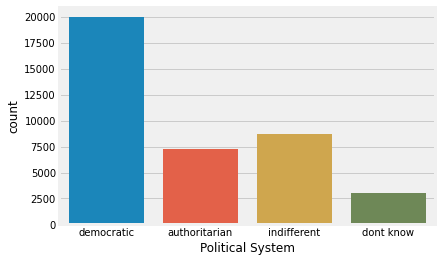

In [39]:
# The following columns values will be used to as classes that we'll try to classify.
class_col = 'Political System' 
# Plot the counts of the classes in the dataset.
sns.countplot(lits_2016_selected[class_col]);
lits_2016_selected[class_col].value_counts(normalize=True)

### We can see that the classes for the question we are classifying are imbalanced.
We first try and classify using the existing distribution, after which we try and balance traiing part of the dataset with and without replacement.

In [41]:
def train_test_valid(dataframe,train_prop = 7/10 ,valid_prop = 1/10):
    """
    Function splits the dataset into training, validation and tests sets and retruns dataframes for each set.
    """
    participants = len(dataframe)
    num_train = int(round(participants * train_prop))
    num_valid = int(round(participants * (train_prop+valid_prop)))

    # Shuffle the dataframe
    dataframe = dataframe.sample(frac=1,replace=False)

    # Assign parts of the shuffled dataframe to training and test sets
    train = dataframe.iloc[:num_train,:].copy()
    valid = dataframe.iloc[num_train:num_valid,:].copy()
    test= dataframe.iloc[num_valid:,:].copy()

    # Separate the features from the output (X from Y)

    print("Training set:\t", len(train), "examples")
    print("Valid set:\t", len(valid), "examples")
    print("Test set:\t", len(test), "examples")
    return train, test, valid


# Split the selected features into a trainin, test and validatiion sets
train, test, valid = train_test_valid(lits_2016_selected_clean)

# Number of nearest neighbours we'll use to estimate the class.
nearest_neighb = 7

Training set:	 16598 examples
Valid set:	 2371 examples
Test set:	 4742 examples


### Check that the classifier works

In [42]:
# Copy traiing and test sets
train_not_balanced = train.copy()
test_not_balanced = test.copy()


# Check that the distances can be calculated 
sel_train_feat_with_dist = uf.distances(train_not_balanced, test_not_balanced.iloc[0],class_col).sort_values('Distance',ascending=False)

sel_train_feat_with_dist.head()

,Internet Acess,Age,Monthly Income,Education Level,Books Growing Up,Trust in People,Risktaking,State of Health,News:Newspaper,News:Radio or Tv,...,Past Wealth Level,Predicted Wealth Level,Health,Economy Type_capitalist,Economy Type_dont know,Economy Type_indifferent,Economy Type_social,Gender_men,Gender_women,Distance
33969,1,32,952.380952,7,3,3,2,3,2,7,...,5,8,3,1,0,0,0,1,0,949.314855
1570,1,35,700.000000,7,5,2,10,2,1,4,...,9,2,2,1,0,0,0,0,1,697.076491
16669,1,29,400.000000,8,5,3,4,2,1,4,...,4,5,2,0,0,0,1,0,1,397.063465
787,1,61,360.360360,8,4,2,3,1,7,7,...,4,5,1,1,0,0,0,1,0,358.672086
789,1,60,360.360360,7,4,2,3,2,7,7,...,4,6,2,1,0,0,0,1,0,358.550785


In [43]:
# What is the actual example classification
print('First test row classification: {}'.format(test_not_balanced[class_col].iloc[0]))

# Prediction based on the classification
print('5-NN classification: {}'.format(uf.predict_nn(test_not_balanced.iloc[0], train_not_balanced, nearest_neighb, class_col)))

First test row classification: democratic
5-NN classification: democratic


### Run the classifier on all the test values

In [45]:
test_not_balanced['Guesses'] = test_not_balanced.apply(uf.predict_nn,args=(train_not_balanced, nearest_neighb, class_col), axis = 1)
test_not_balanced.head()

,Internet Acess,Age,Monthly Income,Education Level,Books Growing Up,Trust in People,Risktaking,State of Health,News:Newspaper,News:Radio or Tv,...,Past Wealth Level,Predicted Wealth Level,Health,Economy Type_capitalist,Economy Type_dont know,Economy Type_indifferent,Economy Type_social,Gender_men,Gender_women,Guesses
33609,4,32,3.174603,2,1,3,3,2,4,7,...,3,4,2,1,0,0,0,0,1,democratic
16820,1,69,12.000000,6,2,2,7,3,3,7,...,3,4,3,0,0,1,0,1,0,democratic
37359,1,58,16.129032,3,2,4,3,2,2,7,...,4,3,2,1,0,0,0,1,0,democratic
26604,1,45,5.000000,3,1,4,4,1,1,4,...,5,5,1,0,0,0,1,1,0,democratic
21703,1,45,17.368421,4,4,3,5,3,1,1,...,5,6,3,0,0,0,1,0,1,democratic


### Calculate the accuracy 

In [46]:
def calculate_accuracy(resultsDF,Output):
    """
    Function calculates and prints class and total accuracy given the dataframe
    and the output class column
    """
    # Create a column, that indicates if the guess was correct
    resultsDF['Correct'] = resultsDF['Guesses'] == resultsDF[Output]
    

    # Count correct, incorrect guesses per class
    accuracy = resultsDF.value_counts(['Guesses', 'Correct'])
    
    # For each class print the achieved accuaracy
    cat = np.unique(resultsDF[Output])
    for value in cat:
        # Calculate accuracy fot this class
        achieved_accuracy =  (accuracy[value][True]/accuracy[value].sum())*100
        print('{} - {:2.2f}%:'.format(value,achieved_accuracy))

    # Calculate and print total accuracy
    accuracy = resultsDF.value_counts('Correct')
    achieved_accuracy =  (accuracy[True]/accuracy.sum())*100
    print('\nTotal Accuracy - {:2.2f}%:'.format(achieved_accuracy))



# Calculate and print class and total accuracy.
calculate_accuracy(test_not_balanced,class_col)

authoritarian - 30.23%:
democratic - 58.72%:
dont know - 11.43%:
indifferent - 33.00%:

Total Accuracy - 52.43%:


### Let's try and balance the dataset, and then see how well classification on a balanced dataset performs

### First let's balance without replacing

democratic       0.537641
indifferent      0.218970
authoritarian    0.203956
dont know        0.039433
Name: Political System, dtype: float64

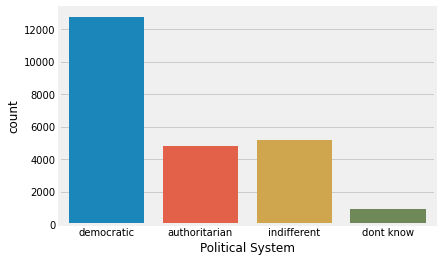

In [48]:
# Plot the current ditribution of the dataset
sns.countplot(lits_2016_selected_clean[class_col]);
lits_2016_selected_clean[class_col].value_counts(normalize=True)

#### You can see that the 'dont know' class has the lowest representation in the training data set

In [56]:
def balance_df(dataframe,Output,bootstrap = False):
    """
    Passing in the dataframe and the output category, returns a dataframe with a 
    balanced number of output clases
    """
    categories = np.unique(dataframe[Output]) # the unique classes

    balancedDf = pd.DataFrame()
    if bootstrap == False:
        # Find the maximum number of rows without replacement
        max_len = dataframe[Output].value_counts(ascending=True)[0]

        for cat in categories:
            df = dataframe[dataframe[Output]==cat].copy()
            df = df.sample(frac=1,replace=False).iloc[:max_len,:]
            balancedDf = pd.concat([balancedDf,df])
    else:
        # Find the maximum number of rows with replacement
        max_len = dataframe[Output].value_counts()[0]
        min_len = dataframe[Output].value_counts()[-1]
        fraction = round(max_len/min_len)

        for cat in categories:
            df = dataframe[dataframe[Output]==cat].copy()
            df = df.sample(frac=fraction,replace=True).iloc[:max_len,:]
            balancedDf = pd.concat([balancedDf,df])
    return balancedDf


# Copy original split into new dataframes to not mix up guess outputs
train_balanced_not_boot = train.copy()
test_balanced_not_boot = test.copy()

# Balance the training dataset, by equaling the dataset size to the smallest size of the claseses.
train_not_bootstrap = balance_df(train_balanced_not_boot,class_col)

#### Here you can see that after balancing without replacement all classes have equal number of rows equal to the lowest number of rows in the original training set dataframe.

indifferent      669
authoritarian    669
dont know        669
democratic       669
Name: Political System, dtype: int64

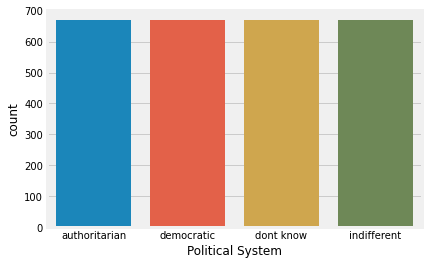

In [57]:
sns.countplot(train_not_bootstrap[class_col]);
train_not_bootstrap[class_col].value_counts()

In [54]:
#  Run the classifier on all the test values from the balanced training dataset
test_balanced_not_boot['Guesses'] = test_balanced_not_boot.apply(uf.predict_nn,args=(train_not_bootstrap, nearest_neighb, class_col), axis = 1)

# Check for accuracy
calculate_accuracy(test_balanced_not_boot,class_col)

authoritarian - 25.28%:
democratic - 62.06%:
dont know - 4.39%:
indifferent - 25.69%:

Total Accuracy - 30.32%:


### Accuracy has actually dropped significanlty. Let's try now with replacement

Political System
authoritarian    8933
democratic       8933
indifferent      8933
dont know        8697
dtype: int64

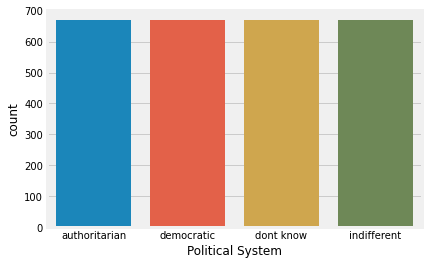

In [58]:
# Copy original split into new dataframes to not mix up guess outputs
train_balanced_boot = train.copy()
test_balanced_boot = test.copy()

# Balance the training dataset, by equaling the dataset size to the smallest size of the claseses.
train_balanced_boot = balance_df(train_balanced_boot,class_col,bootstrap=True)

# Here you can see that after balancing with replacement all classes have equal number of rows equal to the highest number of rows in the original training set dataframe.
sns.countplot(train_not_bootstrap[class_col]);
train_balanced_boot.value_counts(class_col)

In [59]:
#  Run the classifier on all the test values from the balanced training dataset
test_balanced_boot['Guesses'] = test_balanced_boot.apply(uf.predict_nn,args=(train_balanced_boot, nearest_neighb, class_col), axis = 1)

# Check for accuracy
calculate_accuracy(test_balanced_boot,class_col)

authoritarian - 24.05%:
democratic - 61.77%:
dont know - 5.37%:
indifferent - 26.95%:

Total Accuracy - 35.51%:


## IV) Conclusion part 1

Following the manual selection, cleaning and adjustment of data, around 50% accuracy was achieved. Attempts at balancing data, did not yield improvements in accuracy, possibly due to the method implemented for balancing.

#### We test the most successful classifier implementation without balancing on the validation dataset.

In [61]:
#  Run the classifier on all the validation values using the not balanced dataset
valid['Guesses'] = valid.apply(uf.predict_nn,args=(train_not_balanced, nearest_neighb, class_col), axis = 1)

# Check for accuracy
calculate_accuracy(valid,class_col)

authoritarian - 30.52%:
democratic - 55.18%:
dont know - 4.55%:
indifferent - 34.97%:

Total Accuracy - 49.68%:
